# Load libaries

Install required packages with pip

In [ ]:
pip install transformers

In [ ]:
pip install seqeval

In [ ]:
pip install Keras-Preprocessing

In [ ]:
pip install tqdm

In [ ]:
# Import libraries
import csv
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig, BertForTokenClassification, AdamW, get_linear_schedule_with_warmup
from keras.layers import Layer
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tqdm import trange
from seqeval.metrics import f1_score, accuracy_score, classification_report, recall_score, precision_score

# Importing data

In [ ]:
# Load data
#data = pd.read_csv('/content/drive/MyDrive/Thesis/IOB_basic.csv', sep=';', encoding="utf-8")
data = pd.read_csv('/content/drive/MyDrive/Thesis/IOB_extended.csv', sep=';', encoding="utf-8")

# map all nan to 'O' so it is a string
data = data.fillna('O')
# removing newlines
data = data.replace('\r',' ', regex=True)
data = data.dropna()

In [ ]:
# Set up the table to store the results
results_table = pd.DataFrame(columns=["Repetition", "F1-Score", "Recall", "Precision"])
# Set up a dictionary to store tag metrics dataframes for each tag
tag_metrics_dict = {}
# Set up a variable to accumulate the confusion matrices
combined_cm = None

# BERT fine-tuning

In [ ]:
# Specify the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)
model = BertForTokenClassification.from_pretrained('bert-base-cased', num_labels=2)
model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['cl

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [ ]:
# tokenize all sentences
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [ ]:
# Repeat the training and evaluation for 40 repetitions
for repetition in range(1):
    # Code for preprocessing, model setup, and training
    class SentenceGetter(object):

        def __init__(self, data):
            self.n_sent = 1
            self.data = data
            self.empty = False
            agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["token"].values.tolist(),
                                                              s["pos"].values.tolist(),
                                                              s["tag"].values.tolist())]
            self.grouped = self.data.groupby("question").apply(agg_func)
            self.sentences = [s for s in self.grouped]

        def get_next(self):
            try:
                s = self.grouped["Question: {}".format(self.n_sent)]
                self.n_sent += 1
                return s
            except:
                return None

    getter = SentenceGetter(data)
    sentences = getter.sentences

    #sentences in the dataset with their correpsonding tokens-words
    sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
    sentences[0]

    #The sentences are annotated with the IOB-schema and the labels look like this.
    labels = [[s[2] for s in sentence] for sentence in getter.sentences]
    print(labels[0])

    # Add PAD tag and create id's of tags
    tag_values = list(set(data["tag"].values))
    tag_values.append("PAD")
    tag2idx = {t: i for i, t in enumerate(tag_values)}

    #Apply Bert
    #define sequence length to 128 tokens and use a batch size of 2
    MAX_LEN = 128
    bs = 2
    # trbs = 4
    # vabs = 2

    # load the pretrained tokenizer 'bert-base-cased' --> cased because it is well-suited for our sentences
    tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

    # tokenize all sentences
    def tokenize_and_preserve_labels(sentence, text_labels):
        tokenized_sentence = []
        labels = []

        for word, label in zip(sentence, text_labels):

            # Tokenize the word and count # of subwords the word is broken into
            tokenized_word = tokenizer.tokenize(word)
            n_subwords = len(tokenized_word)

            # Add the tokenized word to the final tokenized word list
            tokenized_sentence.extend(tokenized_word)

            # Add the same label to the new list of labels `n_subwords` times
            labels.extend([label] * n_subwords)

        return tokenized_sentence, labels

    tokenized_texts_and_labels = [
        tokenize_and_preserve_labels(sent, labs)
        for sent, labs in zip(sentences, labels)
    ]

    tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
    labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

    #cut and pad the token and label sequences to our desired length
    input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                              maxlen=MAX_LEN, dtype="long", value=0.0,
                              truncating="post", padding="post")

    tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                        maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                        dtype="long", truncating="post")

    #create masks to ignore the padded elements in the sequences (similarly to the masking in keras).
    attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]


    #split the dataset to train and test set
    tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                                random_state=None, test_size=0.1)

    tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                                random_state=None, test_size=0.1)

    # Given that we are operating in pytorch, we should convert the datasets to torch tensors
    tr_inputs = torch.tensor(tr_inputs)
    val_inputs = torch.tensor(val_inputs)
    tr_tags = torch.tensor(tr_tags)
    val_tags = torch.tensor(val_tags)
    tr_masks = torch.tensor(tr_masks)
    val_masks = torch.tensor(val_masks)

    #define the dataloaders--> shuffle the data at training time with the RandomSampler and at test time pass them sequentially with the SequentialSampler
    train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

    valid_data = TensorDataset(val_inputs, val_masks, val_tags)
    valid_sampler = SequentialSampler(valid_data)
    valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

    #load the pretrained bert-base-cased model and provide the number of possible labels.
    model = BertForTokenClassification.from_pretrained(
        "bert-base-cased",
        num_labels=len(tag2idx),
        output_attentions = False,
        output_hidden_states = False
    )

    model.to('cuda')

    # Before starting the fine-tuning process, setup the optimizer and add the parameters it should update
    FULL_FINETUNING = True
    if FULL_FINETUNING:
        param_optimizer = list(model.named_parameters())
        no_decay = ['bias', 'gamma', 'beta']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
            'weight_decay_rate': 0.01},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
            'weight_decay_rate': 0.0}
        ]
    else:
        param_optimizer = list(model.classifier.named_parameters())
        optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

    optimizer = AdamW(
        optimizer_grouped_parameters,
        lr=5e-5,
        eps= 1e-8
    )

    epochs = 4
    max_grad_norm = 10

    # Total number of training steps is number of batches * number of epochs.
    total_steps = len(train_dataloader) * epochs

    # Create a learning rate scheduler to linearly reduce the learning rate throughout the epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    #Fit BERT for named entity recognition
    #load evaluation metrics


    #Fine-tune the BERT model
    ## Store the average loss after each epoch so we can plot them.
    loss_values, validation_loss_values = [], []
    correct= 0

    for _ in trange(epochs, desc="Epoch"):
        # ========================================
        #               Training
        # ========================================
        # Perform one full pass over the training set.

        # Put the model into training mode.
        model.train()
        # Reset the total loss for this epoch.
        total_loss = 0

        # Training loop
        for step, batch in enumerate(train_dataloader):
            # add batch to gpu
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            # Always clear any previously calculated gradients before performing a backward pass.
            model.zero_grad()
            # forward pass
            # This will return the loss (rather than the model output)
            # because we have provided the `labels`.
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

            # get the loss
            loss = outputs[0]
            # Perform a backward pass to calculate the gradients.
            loss.backward()
            # track train loss
            total_loss += loss.item()
            # Clip the norm of the gradient
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
            # update parameters
            optimizer.step()
            # Update the learning rate.
            scheduler.step()

        # Calculate the average loss over the training data.
        avg_train_loss = total_loss / len(train_dataloader)
        print("Average train loss: {}".format(avg_train_loss))

        # Store the loss value for plotting the learning curve.
        loss_values.append(avg_train_loss)

        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        # Put the model into evaluation mode
        model.eval()
        # Reset the validation loss for this epoch.
        eval_loss, eval_accuracy = 0, 0
        nb_eval_steps, nb_eval_examples = 0, 0
        predictions, true_labels = [], []
        for batch in valid_dataloader:
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch

            # Telling the model not to compute or store gradients,
            # saving memory and speeding up validation
            with torch.no_grad():
                # Forward pass, calculate logit predictions.
                # This will return the logits rather than the loss because we have not provided labels.
                outputs = model(b_input_ids, token_type_ids=None,
                                attention_mask=b_input_mask, labels=b_labels)
            # Move logits and labels to CPU
            logits = outputs[1].detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences.
            eval_loss += outputs[0].mean().item()
            predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
            true_labels.extend(label_ids)

        eval_loss = eval_loss / len(valid_dataloader)
        validation_loss_values.append(eval_loss)
        print("Validation loss: {}".format(eval_loss))
        pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                    for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
        valid_tags = [tag_values[l_i] for l in true_labels
                                      for l_i in l if tag_values[l_i] != "PAD"]
        print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
        #print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
        print(classification_report([pred_tags], [valid_tags]))

    # BERT Evaluation Metrics
    # number of total entities per tag in the validation/test set
    from collections import Counter
    c = Counter(valid_tags)

    print( c.items() )

    print("F1-score is : {:.1%}".format(f1_score([pred_tags], [valid_tags])))

    print("Recall is : {:.1%}".format(recall_score([pred_tags], [valid_tags])))

    print("Precision is : {:.1%}".format(precision_score([pred_tags], [valid_tags])))

    # ... (Code for evaluation metrics calculation)

    # Get the unique tags for the axes labels
    tags = sorted(list(set(valid_tags + pred_tags)))

    # Calculate performance metrics for all unique IOB-tags
    precision = precision_score([valid_tags], [pred_tags], average=None)
    recall = recall_score([valid_tags], [pred_tags], average=None)
    f1 = f1_score([valid_tags], [pred_tags], average=None)

    # Store the results in the table
    results_table = results_table.append({
        "Repetition": repetition + 1,
        "F1-Score": f1_score([pred_tags], [valid_tags]),
        "Recall": recall_score([pred_tags], [valid_tags]),
        "Precision": precision_score([pred_tags], [valid_tags])
    }, ignore_index=True)


    # Calculate tag metrics for each unique tag
    tag_metrics = classification_report([pred_tags], [valid_tags], output_dict=True, zero_division=0.0)
    for tag, metrics in tag_metrics.items():
        if tag != "micro avg" and tag != "macro avg" and tag != "weighted avg":
            if tag not in tag_metrics_dict:
                tag_metrics_dict[tag] = pd.DataFrame(columns=["Repetition", "True Tags", "Predicted Tags", "True Positive", "False Positive", "False Negative", "F1-Score", "Recall", "Precision"])
            tag_metrics_dict[tag] = tag_metrics_dict[tag].append({
                "Repetition": repetition + 1,
                "True Tags": tag,
                "Predicted Tags": tag,
                "True Positive": metrics.get("tp", 0),
                "False Positive": metrics.get("fp", 0),
                "False Negative": metrics.get("fn", 0),
                "F1-Score": metrics["f1-score"],
                "Recall": metrics["recall"],
                "Precision": metrics["precision"]
            }, ignore_index=True)


# Print the results table
print(results_table)

# Print tag metrics dataframes for each unique tag
for tag, metrics_df in tag_metrics_dict.items():
    print(f"Tag: {tag}")
    print(metrics_df)
    print()

# Print performance metrics for all unique IOB-tags
if len(tags) == len(precision) == len(recall) == len(f1):
    for i, tag in enumerate(tags):
        print(f"Tag: {tag}")
        print(f"Precision: {precision[i]}")
        print(f"Recall: {recall[i]}")
        print(f"F1-Score: {f1[i]}")
        print()

['O', 'O', 'O', 'O', 'B-obj', 'I-obj', 'O', 'O', 'O', 'O']


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['cl

Average train loss: 0.30632473190111675


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PAD seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:25<01:16, 25.57s/it]

Validation loss: 0.12184387240558862
Validation Accuracy: 0.7606299212598425
              precision    recall  f1-score   support

          AD       0.00      0.00      0.00         9
        cnac       0.00      0.00      0.00         0
       cnaer       0.00      0.00      0.00         0
        cval       0.00      0.00      0.00         0
        fldn       0.00      0.00      0.00         0
        fldo       0.00      0.00      0.00         0
        fldr       0.00      0.00      0.00         0
         net       0.00      0.00      0.00         0
         obj       0.30      0.11      0.16       147
     objcnac       0.00      0.00      0.00         0
    objcnaer       0.00      0.00      0.00         0
       objqb       0.00      0.00      0.00         0
       objqo       0.00      0.00      0.00         0
    ococnpir       0.00      0.00      0.00         0
     ococnpr       0.00      0.00      0.00         0
     ococvpr       0.00      0.00      0.00         0
    

Epoch:  50%|█████     | 2/4 [00:40<00:38, 19.27s/it]

Validation loss: 0.09068983886390924
Validation Accuracy: 0.831496062992126
              precision    recall  f1-score   support

        cnac       0.00      0.00      0.00         0
       cnaer       0.00      0.00      0.00         0
        cval       0.00      0.00      0.00         1
        fldn       0.00      0.00      0.00         0
        fldo       0.00      0.00      0.00         0
        fldr       0.75      0.21      0.33        14
         net       0.00      0.00      0.00         0
         obj       0.74      0.44      0.55        89
     objcnac       0.00      0.00      0.00         0
    objcnaer       0.00      0.00      0.00         0
       objqb       0.00      0.00      0.00         0
       objqo       0.00      0.00      0.00         0
    ococnpir       0.00      0.00      0.00         0
     ococnpr       0.00      0.00      0.00         0
     ococvpr       0.00      0.00      0.00         0
      propir       0.00      0.00      0.00         0

   m

Epoch:  75%|███████▌  | 3/4 [00:55<00:17, 17.31s/it]

Validation loss: 0.07232576906681061
Validation Accuracy: 0.8645669291338582
              precision    recall  f1-score   support

        cnac       0.00      0.00      0.00         0
       cnaer       0.00      0.00      0.00         0
        cval       0.29      0.50      0.36         4
        fldn       0.00      0.00      0.00         2
        fldo       0.00      0.00      0.00         0
        fldr       1.00      0.31      0.47        13
         net       0.00      0.00      0.00         0
         obj       0.72      0.59      0.65        64
     objcnac       0.00      0.00      0.00         1
    objcnaer       0.00      0.00      0.00         0
       objqb       0.00      0.00      0.00         0
       objqo       0.00      0.00      0.00         3
       objqr       0.00      0.00      0.00         2
    ococnpir       0.00      0.00      0.00         4
     ococnpr       0.00      0.00      0.00         0
     ococvpr       0.80      1.00      0.89         4
    

Epoch: 100%|██████████| 4/4 [01:10<00:00, 17.64s/it]

Validation loss: 0.06695246892049908
Validation Accuracy: 0.8929133858267716
              precision    recall  f1-score   support

        cnac       0.00      0.00      0.00         0
       cnaer       0.00      0.00      0.00         0
        cval       0.86      1.00      0.92         6
        fldn       0.50      0.33      0.40         3
        fldo       0.00      0.00      0.00         0
        fldr       1.00      0.50      0.67         8
         net       0.00      0.00      0.00         0
         obj       0.74      0.58      0.65        67
     objcnac       1.00      0.67      0.80         3
    objcnaer       0.00      0.00      0.00         0
       objqb       0.00      0.00      0.00         1
       objqo       0.00      0.00      0.00         2
    ococnpir       0.20      0.25      0.22         4
     ococnpr       0.00      0.00      0.00         0
     ococvpr       1.00      0.83      0.91         6
      propir       0.33      0.17      0.22         6

   


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-17-2c62ba5de5fd>:278: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({
<ipython-input-17-2c62ba5de5fd>:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tag_metrics_dict[tag] = tag_metrics_dict[tag].append({
<ipython-input-17-2c62ba5de5fd>:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tag_metrics_dict[tag] = tag_metrics_dict[tag].append({
<ipython-input-17-2c62ba5de5fd>:292: FutureWarning

# BERT Evaluation Metrics

In [ ]:
# Calculate mean values
mean_values = results_table.mean()
print(mean_values)

Repetition    1.000000
F1-Score      0.590000
Recall        0.556604
Precision     0.627660
dtype: float64


In [ ]:
# Combine results_table and tags_metrics DataFrames
combined_df = pd.concat([results_table] + list(tag_metrics_dict.values()))

# Calculate average metrics
average_metrics = combined_df.groupby('True Tags').mean().reset_index()

<ipython-input-22-9e29156da55c>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  average_metrics = combined_df.groupby('True Tags').mean().reset_index()


In [ ]:
# Show average metrics DataFrame
average_metrics

,True Tags,F1-Score,Recall,Precision
0,AD,0.000000,0.000000,0.000000
1,cnac,0.929960,0.932292,0.956250
2,cnaer,0.000000,0.000000,0.000000
3,cvaer,0.000000,0.000000,0.000000
4,cval,0.673535,0.574683,0.851607
5,fldb,0.000000,0.000000,0.000000
6,fldi,0.000000,0.000000,0.000000
7,fldn,0.437647,0.415852,0.510541
8,fldo,0.000000,0.000000,0.000000
9,fldr,0.596381,0.554609,0.714304


In [ ]:
# Calculate tag occurrences
tag_occurrences = combined_df.groupby('True Tags').size().reset_index(name='Occurrences')

# Calculate average metrics
average_metrics = combined_df.groupby('True Tags').mean().reset_index()

# Merge average metrics with tag occurrences
average_metrics = average_metrics.merge(tag_occurrences, on='True Tags')

<ipython-input-23-43d048e8293e>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  average_metrics = combined_df.groupby('True Tags').mean().reset_index()


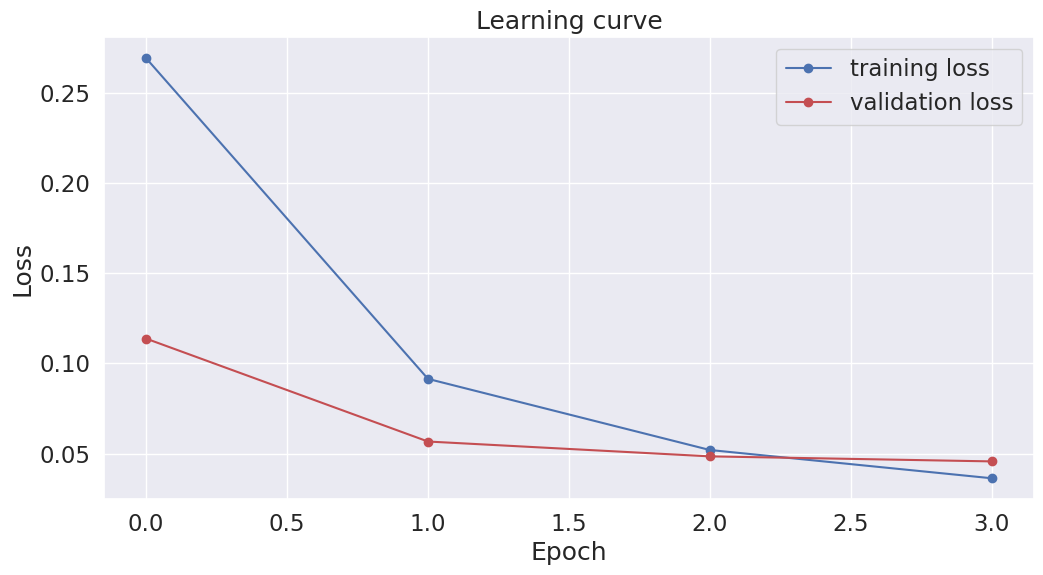

None


In [ ]:
# Plot training and validation loss of the model for each epoch
import matplotlib.pyplot as plt
plt.show()

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

print(plt.show())

In [ ]:
# Confusion matrix
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Assuming valid_tags and pred_tags contain the true and predicted labels, respectively

# Create the confusion matrix
cm = confusion_matrix(valid_tags, pred_tags)

# Get the unique tags for the axes labels
tags = sorted(list(set(valid_tags + pred_tags)))

# Calculate performance metrics
precision = precision_score(valid_tags, pred_tags, average=None)
recall = recall_score(valid_tags, pred_tags, average=None)
f1 = f1_score(valid_tags, pred_tags, average=None)

# Create the DataFrame
data = {
    "True Tags": tags,
    "Predicted Tags": tags,
    "True Positive": cm.diagonal(),
    "False Positive": cm.sum(axis=0) - cm.diagonal(),
    "False Negative": cm.sum(axis=1) - cm.diagonal(),
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1
}
df = pd.DataFrame(data)

# Display the confusion matrix and performance metrics
print(df)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




```
# This is formatted as code
```

# Model's performance on three sentences

In [ ]:
# List of validation questions
# validation_questions = [
    "What is the motor vehicle fatality rate for every month in the United States in 2020?",
    "What is the service area of the hospital in Breda?",
    "What are the different zoning types in the city centre of Amsterdam?"]

In [ ]:
test_sentence = "What are the different zoning types in the city centre of Amsterdam?"
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()

with torch.no_grad():
     output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

PAD	[CLS]
O	What
O	are
PAD	the
PAD	different
PAD	zoning
O	types
O	in
O	the
PAD	city
PAD	centre
PAD	of
PAD	Amsterdam
PAD	?
PAD	[SEP]
